In [14]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import xgboost as xgb

import shap
import os
import sys
import collections
import torch

from scipy import stats
from shapreg import shapley, games, removal, shapley_sampling
from sklearn.impute import SimpleImputer
from sklearn import  preprocessing, model_selection
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


from captum.attr import (
    DeepLift,
    FeatureAblation,
    FeaturePermutation,
    IntegratedGradients,
    KernelShap,
    Lime,
    ShapleyValueSampling,
    GradientShap,
)


module_path = os.path.abspath(os.path.join('../CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import catenets.models.torch.pseudo_outcome_nets as pseudo_outcome_nets
import catenets.models as cate_models
import catenets.models.torch.tlearner as tlearner

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
def plot_feature_values(feature_values):
    
    ind = np.argpartition(np.abs(feature_values).mean(0).round(2), -15)[-15:]
    
    feature_names = [
        a + ": " + str(b) for a,b in zip(names[ind], np.abs(feature_values[:, ind]).mean(0).round(2))
    ]

    shap.summary_plot(
        feature_values[:, ind],
        x_test[:, ind], 
        feature_names=feature_names,
        title = "IG"
     )
    
def plot_feature_values_ind(feature_values, indices):
    
    selected_sample = feature_values[indices]
    filtered_test = x_test[indices]
    
    ind = np.argpartition(np.abs(selected_sample).mean(0).round(2), -15)[-15:]
    
    feature_names = [
        a + ": " + str(b) for a,b in zip(names[ind], np.abs(selected_sample[:, ind]).mean(0).round(2))
    ]

    shap.summary_plot(
        selected_sample[:, ind],
        filtered_test[:, ind], 
        feature_names=feature_names,
        title = "IG"
     )

def normalize_data(X):
    
    X = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

    return X

In [16]:
#### filtering out procedure

fluid_cohort = pd.read_pickle("../data/low_bp_survival.pkl")
#fluid_cohort = pd.read_pickle("data/trauma_team_activated.pkl")
#fluid_cohort = pd.read_pickle("data/trauma_responder.pkl")

#
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='proc')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='ethnicity')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='residencestate')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='toxicologyresults')))]

x = fluid_cohort.loc[:, ~fluid_cohort.columns.isin(["registryid",
                                                            "COV",
                                                            "TT",
                                                            "scenegcsmotor",
                                                            "scenegcseye",
                                                            "scenegcsverbal",
                                                            "edgcsmotor",
                                                            "edgcseye",
                                                            "edgcsverbal",
                                                            "outcome",
                                                            "sex_F"
                                                            ])]

### normalize x_train 
#x = x_train.values 

n, feature_size = x.shape
names = x.drop(['treated'],axis = 1).columns
treatment_index = x.columns.get_loc("treated")
sex_index = x.columns.get_loc("sex_M")


var_index = [i for i in range(feature_size) if i != treatment_index]

x_norm = normalize_data(x)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(x_norm)
x_train_scaled = imp.transform(x_norm)

x_train, x_test, y_train, y_test = model_selection.train_test_split(
                                             x_train_scaled,  
                                             fluid_cohort["outcome"], 
                                             test_size=0.3, 
                                             random_state=10,
                                             stratify=fluid_cohort["outcome"]
                                    )

w_train = x_train[:, treatment_index]
w_test =  x_test[:, treatment_index]

x_train = x_train[:,var_index]
x_test = x_test[:, var_index]


device = "cpu"

# learner_explanations = {}

# #### Getting top 10 features from multiple runs. 

# results_train = np.zeros((50, len(x_train)))
# results_test = np.zeros((50, len(x_test)))


# # for i in range(50):
# model = cate_models_masks.XLearner(  
#                                         x_train.shape[1],
#                                         binary_y=(len(np.unique(y_train)) == 2),
#                                         n_layers_out=2,
#                                         n_units_out=30,
#                                         batch_size=256,
#                                         n_iter=500,
#                                         nonlin="relu",
#                                         device=device,
#                                     )

# model.fit(x_train, y_train, w_train)

# results_train[i] = model(x_train).detach().cpu().numpy().flatten()
# results_test[i] = model(x_test).detach().cpu().numpy().flatten()

In [19]:
learners = {
    "XLearner":pseudo_outcome_nets.XLearner(  
                x_train.shape[1],
                binary_y=(len(np.unique(y_train)) == 2),
                n_layers_out=2,
                n_units_out=100,
                batch_size=128,
                n_iter=1000,
                nonlin="relu",
                device="cuda:1"
            ),
    "DRLearner": pseudo_outcome_nets.DRLearner(
               x_train.shape[1],
               binary_y=(len(np.unique(y_train)) == 2),
                n_layers_out=2,
                n_units_out=100,
                batch_size=128,
                n_iter=1000,
                nonlin="relu",
                device="cuda:1"
           ),
    "SLearner": cate_models.torch.SLearner(
               x_train.shape[1],
               binary_y=(len(np.unique(y_train)) == 2),
                n_layers_out=2,
                n_units_out=100,
                batch_size=128,
                n_iter=1000,
                nonlin="relu",
                device="cuda:1"
           ),
    "TLearner": cate_models.torch.TLearner(
               x_train.shape[1],
               binary_y=(len(np.unique(y_train)) == 2),
                n_layers_out=2,
                n_units_out=100,
                batch_size=128,
                n_iter=1000,
                nonlin="relu",
                device="cuda:1"
           ),
    
}

trials = 5

if_results = np.zeros(( trials, len(learners)))
seeds = np.arange(0, 5, 1, dtype=int)


for i, seed in enumerate(seeds):
    np.random.seed(seed)
    
    # train plugin-estimator
    
    xgb_plugin1 = xgb.XGBClassifier(max_depth=6, random_state=seed, n_estimators=100)
    xgb_plugin0 = xgb.XGBClassifier(max_depth=6, random_state=seed, n_estimators=100)   

    rf = RandomForestClassifier(max_depth=6, random_state=seed)

    x0 = x_train[w_train==0]
    x1 = x_train[w_train==1]

    y0 = y_train[w_train==0]
    y1 = y_train[w_train==1]


    xgb_plugin0.fit(x0, y0)
    xgb_plugin1.fit(x1, y1)

    rf.fit(x_train, w_train)

    y_pred0 = xgb_plugin0.predict(x_test)
    y_pred1 = xgb_plugin1.predict(x_test)

    t_plugin = y_pred1 - y_pred0

    ps = rf.predict_proba(x_test)[:, 1]
    a = (w_test - ps)

    ident = np.array([1]*len(ps))
    c = (ps*(ident-ps))

    b = np.array([2]*len(w_test))*w_test*(w_test-ps) / c

    for learner_idx, (learner_name,_ ) in enumerate(learners.items()):
        
        model = learners[learner_name]
        model.fit(x_train, y_train, w_train)

        cate = model.predict(x_test).detach().cpu().numpy()
        cate = cate.flatten()

        plug_in = (t_plugin-cate)**2
        l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)
        
        if_results[i, learner_idx] = np.mean(l_de) + np.mean(plug_in)

[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.7192707061767578, train_loss: 0.6935679316520691
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.5614519715309143, train_loss: 0.47836199402809143
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.4821922481060028, train_loss: 0.3499840795993805
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.4419049918651581, train_loss: 0.2602139711380005
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.41770845651626587, train_loss: 0.20034167170524597
[po_estimator_0_impute_pos] Epoch: 250, current validation loss: 0.40547844767570496, train_loss: 0.15795524418354034
[po_estimator_0_impute_pos] Epoch: 300, current validation loss: 0.39813849329948425, train_loss: 0.12578043341636658
[po_estimator_0_impute_pos] Epoch: 350, current validation loss: 0.3949086368083954, train_loss: 0.10174814611673355
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.72

In [20]:
print(np.mean(if_results,axis=0))

[0.36651264 0.53478916 0.14422012 0.38808147]


In [23]:
import pickle 
import xgboost as xgb
import random
from sklearn import metrics


results_train = pickle.load(open("results/massive_trans/result_train_xlearner.pkl", "rb"))
results_test = pickle.load(open("results/massive_trans/result_test_xlearner.pkl", "rb"))

print(results_test.shape)
results_train = results_train.reshape(5, -1)
results_test = results_test.reshape(5, -1)

print(np.mean(results_train), np.std(results_train)/np.sqrt(results_train.shape[1]))
print(np.mean(results_test), np.std(results_test)/np.sqrt(results_test.shape[1]))

estimated_ate_train = np.mean(results_train, axis=0)
estimated_ate_test = np.mean(results_test, axis=0)

print(estimated_ate_test.shape)
threshold = np.mean(estimated_ate_train)

gender = x.columns.get_loc("sex_M")
trauma = x.columns.get_loc("traumatype_B")
temp = x.columns.get_loc("temps2")
fio2 = x.columns.get_loc("FIO2")
ph = x.columns.get_loc("PH")

cause_cut = x.columns.get_loc("causecode_CUT")
cause_GUN = x.columns.get_loc("causecode_GUN")
scenegcs = x.columns.get_loc("scenegcs")
edgcs = x.columns.get_loc("edgcs")


scenefirstbloodpressure = x.columns.get_loc("scenefirstbloodpressure")


lac  = x.columns.get_loc("LAC")
inr  = x.columns.get_loc("INR")
hgb  = x.columns.get_loc("HGB")
na = x.columns.get_loc("NA")
bd = x.columns.get_loc("BD")
pulse = x.columns.get_loc("edfirstpulse")



y_true_train = (estimated_ate_train > threshold)
y_true_test = (estimated_ate_test > threshold)

top_2_train = x_train[:, [gender,trauma ,cause_cut, edgcs, scenegcs ]]
top_2_test = x_test[:, [gender, trauma ,cause_cut, edgcs, scenegcs]]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_2_train, y_true_train)

y_pred = xgb_model.predict(top_2_test)
ate = np.sum(estimated_ate_test[y_pred == 1])/n

auroc = metrics.roc_auc_score(y_true_test, y_pred)

print("original", np.sum(estimated_ate_test[w_test==1])/n)

print("shap",auroc)
print("shap - ate", ate)

# top_2_train = x_train[:, [temp, ph, bd, hgb, pulse ]]
# top_2_test = x_test[:, [temp, ph, bd, hgb, pulse ]]

# xgb_model = xgb.XGBClassifier(objective="binary:logistic")
# xgb_model.fit(top_2_train, y_true_train)

# y_pred = xgb_model.predict(top_2_test)
# auroc = metrics.roc_auc_score(y_true_test, y_pred)
# ate = np.sum(estimated_ate_test[y_pred == 1])/n

# print("shap- 0",auroc)
# print("shap-0 - ate", ate)

# top_2_train = x_train[:, [ph, na, temp, gender, fio2 ]]
# top_2_test = x_test[:, [ph, na, temp, gender, fio2 ]]

# xgb_model = xgb.XGBClassifier(objective="binary:logistic")
# xgb_model.fit(top_2_train, y_true_train)

# y_pred = xgb_model.predict(top_2_test)
# auroc = metrics.roc_auc_score(y_true_test, y_pred)
# ate = np.sum(estimated_ate_test[y_pred == 1])/n

# print("ig",auroc)
# print("ig - ate", ate)

# top_2_train = x_train[:, [lac, inr, hgb,scenefirstbloodpressure ]]
# top_2_test = x_test[:, [lac, inr,hgb, scenefirstbloodpressure ]]

# xgb_model = xgb.XGBClassifier(objective="binary:logistic")
# xgb_model.fit(top_2_train, y_true_train)

# y_pred = xgb_model.predict(top_2_test)
# auroc = metrics.roc_auc_score(y_true_test, y_pred)
# ate = np.sum(estimated_ate_test[y_pred == 1])/n

# print("clnical", auroc)
# print("clinical - ate", ate)

# xgb_model = xgb.XGBClassifier(objective="binary:logistic")
# xgb_model.fit(x_train, y_true_train)

# y_pred = xgb_model.predict(x_test)
# ate = np.sum(estimated_ate_test[y_pred == 1])/n

# auroc = metrics.roc_auc_score(y_true_test, y_pred)

# print("full feature", auroc)
# print("full feature - ate", ate)


# random_feature = np.random.randint(x_train.shape[1], size=(4))

# top_2_train = x_train[:, random_feature]
# top_2_test = x_test[:, random_feature]

# xgb_model = xgb.XGBClassifier(objective="binary:logistic")
# xgb_model.fit(top_2_train, y_true_train)

# y_pred = xgb_model.predict(top_2_test)
# ate = np.sum(estimated_ate_test[y_pred == 1])/n

# auroc = metrics.roc_auc_score(y_true_test, y_pred)

# print("random feature", auroc)
# print("random feature - ate", ate)

(5, 201)
-0.023062477658597282 0.00899912391591147
-0.022944787911959547 0.017713969099360866
(201,)


XGBoostError: [16:02:53] ../src/data/data.cc:481: Check failed: this->labels.Size() % this->num_row_ == 0 (101 vs. 0) : Incorrect size for labels.
Stack trace:
  [bt] (0) /homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x154e19) [0x7fdbb0260e19]
  [bt] (1) /homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x1619ea) [0x7fdbb026d9ea]
  [bt] (2) /homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x163770) [0x7fdbb026f770]
  [bt] (3) /homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(XGDMatrixSetInfoFromInterface+0xa4) [0x7fdbb01b2d44]
  [bt] (4) /homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/lib-dynload/../../libffi.so.7(+0x69dd) [0x7fdd0990f9dd]
  [bt] (5) /homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/lib-dynload/../../libffi.so.7(+0x6067) [0x7fdd0990f067]
  [bt] (6) /homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(_ctypes_callproc+0x319) [0x7fdd099281e9]
  [bt] (7) /homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(+0x13c95) [0x7fdd09928c95]
  [bt] (8) /homes/gws/mingyulu/miniconda3/envs/torch_gpu/bin/python(_PyObject_MakeTpCall+0x3bf) [0x55a5e82e613f]



average tx effect -0.18027568
average tx effect -0.18864961


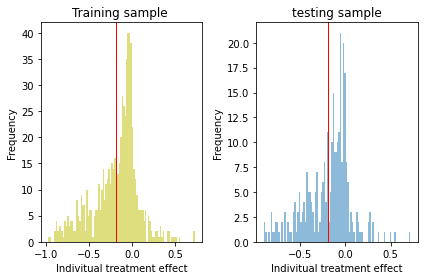

In [21]:
import matplotlib.pyplot as plt 

train_output = model(x_train).detach().cpu().numpy()
test_output = model(x_test).detach().cpu().numpy()

print("average tx effect", np.mean(train_output))
print("average tx effect", np.mean(test_output))

plt.subplot(1,2,1)
plt.hist(train_output, bins=100 ,alpha= 0.5, color="y")
plt.axvline(x= np.mean(train_output), linewidth=1, color='r')

plt.title("Training sample " )
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(test_output,bins=100 , alpha = 0.5)
plt.axvline(x= np.mean(test_output), linewidth=1, color='r')

plt.title("testing sample")
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")
plt.tight_layout()

(50, 302)
(50, 1, 226) (50, 1, 76)
average tx effect: male -0.08552909284615806 0.020815285115837533
average tx effect: female -0.023338479927777753 0.035229039087548326


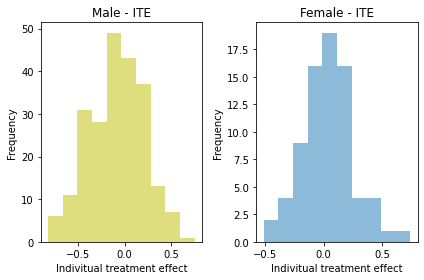

In [71]:
sex_index = x.columns.get_loc("sex_M")

print(results_test.shape)

male = results_test[:, np.where(x_test[:,sex_index] == 1)]
female = results_test[:, np.where(x_test[:,sex_index] == 0) ]

# male_ate = model(male).detach().cpu().numpy()
# female_ate = model(female).detach().cpu().numpy()

print(male.shape, female.shape)

print("average tx effect: male", np.mean(male), np.std(male)/np.sqrt(male.shape[2]))
print("average tx effect: female", np.mean(female), np.std(female)/np.sqrt(female.shape[2]))

plt.subplot(1,2,1)
plt.hist(male[13, 0, : ], alpha= 0.5, color="y")

plt.title("Male - ITE")
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(female[3, 0, :], alpha = 0.5)

plt.title("Female - ITE")
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")
plt.tight_layout()

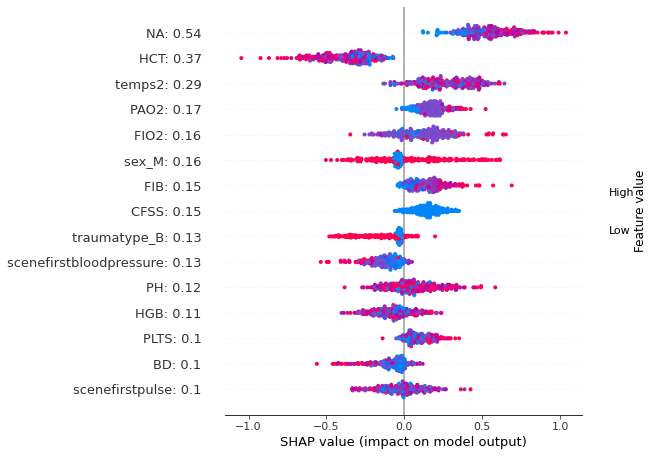

In [244]:
# Shapley value sampling
shapley_value_sampling_model = ShapleyValueSampling(model)

learner_explanations["shapley_sampling_0"] = shapley_value_sampling_model.attribute(
                                                 torch.from_numpy(x_test).to(device).requires_grad_(),
                                                n_samples=500,
                                                perturbations_per_eval=10,
                                            ).detach().cpu().numpy()

plot_feature_values(learner_explanations["shapley_sampling_0"])

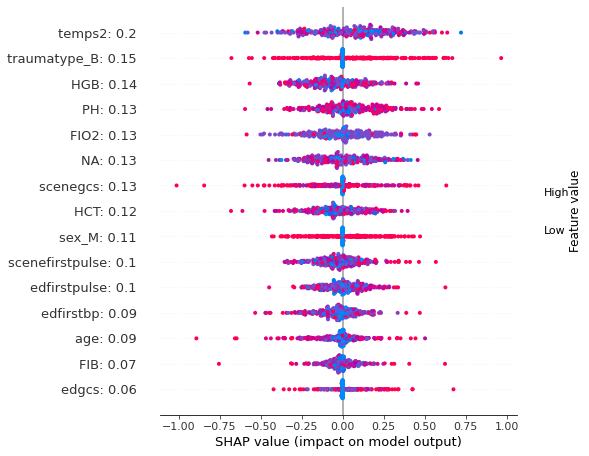

In [79]:
# Shapley value sampling
ig = IntegratedGradients(model)

learner_explanations["ig"] = ig.attribute(
                                    torch.from_numpy(x_test).to(device).requires_grad_(),
                                    n_steps=500,
                            ).detach().cpu().numpy()

plot_feature_values(learner_explanations["ig"])



You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.


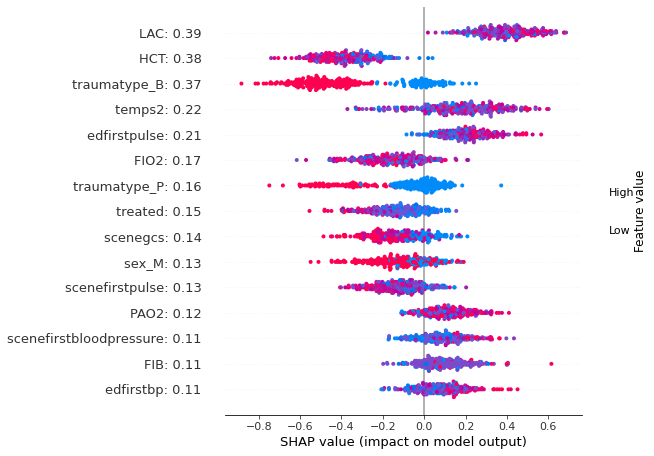

In [147]:
## Kernel shap
kernel_shap_model = KernelShap(model)

learner_explanations["KernelSHAP"] = kernel_shap_model.attribute(
                                             torch.from_numpy(x_test).to(device).requires_grad_(),
                                             n_samples=500,
                                             perturbations_per_eval=10
                                            ).detach().cpu().numpy()

plot_feature_values(learner_explanations["KernelSHAP"])

In [ ]:
learner_explanations["shapley_sampling"] = np.zeros((x_test.shape))
marginal_extension = removal.MarginalExtension(x_test, model)

for test_ind in range(len(x_test)):
    instance = x_test[test_ind]
    game = games.PredictionGame(marginal_extension, instance)
    explanation = shapley_sampling.ShapleySampling(game, thresh=0.03, batch_size=64)
    learner_explanations["shapley_sampling"][test_ind] = explanation.values.reshape(-1, x_test.shape[1])

plot_feature_values(learner_explanations["shapley_sampling"])

100%|████████████████████████████████████████████| 1/1 [02:11<00:00, 131.46s/it]
 12%|████▌                                  | 0.1166/1 [00:13<01:42, 115.74s/it]

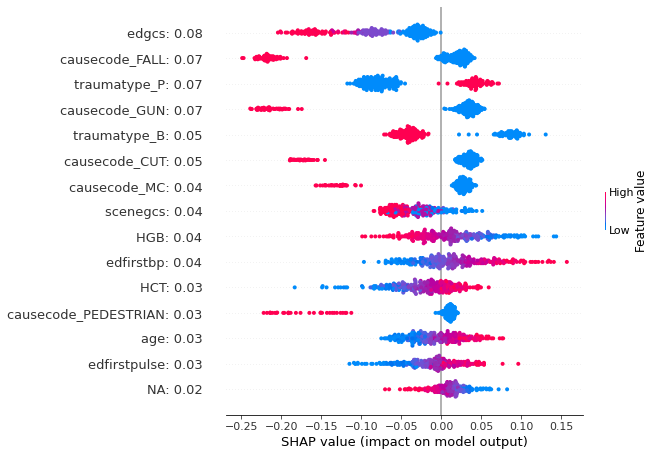

In [97]:
plot_feature_values(learner_explanations["shapley_sampling"])

In [192]:
def calculate_standard_error(feature_values):

    inds = np.argpartition(np.abs(feature_values).mean(0).round(2), -10)[-10:]
    
    print(names[inds])
    std_error = np.zeros(len(inds))
    
    for index, ind in enumerate(inds):
        
        selector = [i for i in range(x_train.shape[1]) if i != ind]
        
        x_train_subset  = x_train[:, selector]
        x_test_subset  = x_test[:, selector]

        subset_model = cate_models_masks.DRLearner(  
                                        x_train_subset.shape[1],
                                        binary_y=(len(np.unique(y_train)) == 2),
                                        n_layers_out=2,
                                        n_units_out=100,
                                        batch_size=256,
                                        n_iter=700,
                                        nonlin="relu",
                                        device=device,
                                        )

        subset_model.fit(x_train_subset, y_train, w_train)
        
        fullset_output =  model(x_test).detach().cpu().numpy()
        subset_output =  subset_model(x_test_subset).detach().cpu().numpy()

        std_error[index] = np.mean((fullset_output - subset_output)**2/np.var(fullset_output))

    return std_error, names[inds]
        
std_error, feature_names = calculate_standard_error(learner_explanations["shapley_sampling"])

Index(['causecode_PEDESTRIAN', 'FIB', 'LAC', 'edgcs', 'traumatype_P',
       'causecode_CUT', 'edfirstbp', 'causecode_GUN', 'causecode_MV',
       'scenegcs'],
      dtype='object')
[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.9770089983940125, train_loss: 1.038055658340454
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.7587620615959167, train_loss: 0.7112215757369995
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.623313307762146, train_loss: 0.5008091330528259
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.524677038192749, train_loss: 0.34882041811943054
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.46228623390197754, train_loss: 0.24860109388828278
[po_estimator_0_impute_pos] Epoch: 250, current validation loss: 0.4270293414592743, train_loss: 0.1862916350364685
[po_estimator_0_impute_pos] Epoch: 300, current validation loss: 0.4044364094734192, train_loss: 0.1449843794107437
[po_estim

Text(0.5, 1.0, 'Standard Error with Feature Masked out - shap - 1.41')

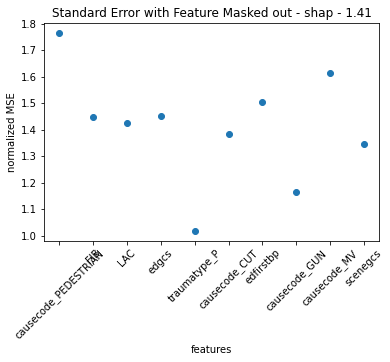

In [193]:

plt.scatter(feature_names , std_error)   
plt.xticks(rotation=45)

plt.ylabel("normalized MSE")
plt.xlabel("features")

plt.title("Standard Error with Feature Masked out - shap - %s"%(np.round(np.mean(std_error),2)))